In [160]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar  
import math

In [161]:
N = norm.cdf


In [181]:
import sympy as sp
import sympy.stats
n = sympy.stats.Normal('n', 0, 1)


In [653]:
def sp_BS_root_put(x0, y0, x, y , S, T, r, sigma):
    
    # x0 is usdc amount at zero time
    TV0 = 2 * sp.sqrt(x0 * y0) * sp.sqrt(S)
    
    z1 = - (r - 0.5*sigma**2)*sp.sqrt(T)/sigma
    first_part = (sp.exp(-r*T) * TV0) * sp.stats.cdf(n)(z1)
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * sp.sqrt(T)
    second_part = (sp.exp(-r*T) * TV0) * (sp.exp(-0.5 * _sigma**2 * T)*sp.exp(_r*T)) * sp.stats.cdf(n)(z2)
    
    return first_part - second_part

def sp_BS_CALL(S, K, T, r, sigma):
    d1 = (sp.log(S/K) + (r + sigma**2/2)*T) / (sigma*sp.sqrt(T))
    d2 = d1 - sigma * sp.sqrt(T)
    return S * sp.stats.cdf(n)(d1) - K * sp.exp(-r*T)* sp.stats.cdf(n)(d2)

In [660]:
x0, y0, x, y, S, K, T, r, sigma, m, v, lam, Nd1, Nd2 = sp.symbols('x0 y0 x y S K T r sigma m v lambda N(d1) N(d2)')

In [268]:
# phi = sp.Function('phi')                                                                                                   

# class Phi(sp.Function): 
#     def _eval_derivative(self, x): 
#         return phi(self.args[0]) * self.args[0].diff(x)

# bs = sp_BS_CALL(S, K, T, r, sigma).diff(S)
# sp.simplify(bs)
# # bs.subs(sp.erf, sp.Lambda(x, 2*Phi(x*sqrt(2))-1))
                                                                                                                        

In [661]:
sp.simplify(sp_BS_root_put(x0, y0, x, y , S, T, r, sigma))

sqrt(S)*sqrt(x0*y0)*((1 - erf(sqrt(2)*sqrt(T)*(r - 0.5*sigma**2)/(2*sigma)))*exp(T*(r + 0.25*sigma**2)/2) + (erf(sqrt(2)*sqrt(T)*r/(2*sigma)) - 1)*exp(T*r))*exp(-T*(3*r + 0.25*sigma**2)/2)

In [662]:
sp.simplify(sp_BS_root_put(x0, y0, x, y , S, T, r, sigma).diff(S))

sqrt(x0*y0)*((1 - erf(sqrt(2)*sqrt(T)*(r - 0.5*sigma**2)/(2*sigma)))*exp(T*(r + 0.25*sigma**2)/2) + (erf(sqrt(2)*sqrt(T)*r/(2*sigma)) - 1)*exp(T*r))*exp(-T*(3*r + 0.25*sigma**2)/2)/(2*sqrt(S))

In [584]:
from scipy.special import erf
erf(1)

0.8427007929497148

In [581]:
N(1)

0.8413447460685429

In [600]:
# works
def delta_BS_root_put(x0, y0, x, y , S, T, r, sigma):
    first_part = (1 - erf(np.sqrt(2*T)*(r-0.5*sigma**2)/(2*sigma)))*np.exp(T*(r+0.25*sigma**2)/2)
    second_part = (erf(np.sqrt(2*T)*(r*0.5/sigma)) - 1)*np.exp(T*r)
    return 0.5*np.sqrt(x0*y0/S)*(first_part + second_part)*np.exp(-T*(3*r+0.25*sigma**2)/2)


In [811]:
x0 = 1000
y0 = 0.5
# it means we put in when price was 1000
# T = 1
r = 0
sigma = 1
# maturity = [t/365 for t in range(0, 365)]
prices = [price for price in range(10, 1000, 20)]

deltas = [delta_BS_root_put(x0,y0, 1,1,price, 0.1, r, sigma) for price in prices]

Text(0, 0.5, 'delta')

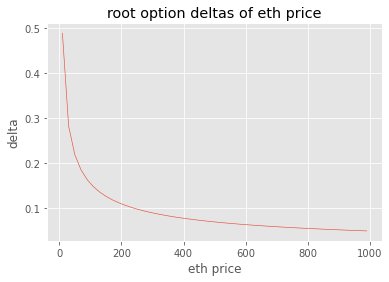

In [812]:
plt.plot(prices, deltas)
plt.title('root option deltas of eth price')
plt.xlabel('eth price')
plt.ylabel('delta')

### (wtf above?!)

In [ ]:
# BS_root_put(500, 0.5 , 1, 1, 1000, 0.5, 0, 1)

In [656]:
# print(sp_BS_root_put(x0, y0, x, y , S, T, r, sigma).evalf(subs={x0:500, y0:0.5, x:1,y:1, S:1000, T:0.5,r:0,sigma:1}))
# print(new_delta_BS_root_put(_x0,_y0,1,1,_S,_T,_r,_sigma))


168.456663677381


In [597]:
# delta_BS_root_put = sp.simplify(sp_BS_root_put(x0, y0, x, y , S, T, r, sigma).diff(S))
# print(delta_BS_root_put)

In [510]:
def BS_root_put(x0, y0, x, y , S, T, r, sigma):
    
    # x0 is usdc amount
    TV0 = 2 * np.sqrt(x0 * y0) * np.sqrt(S)
    
    z1 = - (r - 0.5*sigma**2)*np.sqrt(T)/sigma
    first_part = (np.exp(-r*T) * TV0) * N(z1)
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
    second_part = (np.exp(-r*T) * TV0) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(z2)
    
    return first_part - second_part

In [807]:
params = {x0: 50, y0:50/100, x:1, y:1, S:100, T: 0.5, r:0, sigma:1}
# T = 0.3
# r = 0  
# sigma = 0.9
last_price = []
replicated_payoff = []
true_payoff = []

S = 100
K = 100
T = 0.5
r = 0
sigma = 1


x0 = 50
y0 = x0 / S

# sp_BS_root_put(x0, y0, x, y , S, T, r, sigma)

# delta_BS_root_put.evalf(subs={x0:_x0, y0:_y0, x:1,y:1, S:_S, T:_T,r:_r,sigma:_sigma})

for i in range(len(all_paths[:])):
    asset = 0
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = 0
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = -(delta_BS_root_put(x0,y0,1,1,all_paths[i][j],T-t,r,sigma))
#         print('x0: {}, y0: {}, S[i][j]:{},T-t:{}, asset:{}'.format(x0,y0,all_paths[i][j],T-t, asset))
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_price.append(all_paths[i][-1])
    replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    # max((TV0) - (TV)) - root_put_price
    # max(0, K - S) - put_price
    true_payoff.append(max(0, (2*x0) - (2*y0*np.sqrt(S))* np.sqrt(all_paths[i][-1])) - BS_root_put(x0, y0,1,1, S, T, r, sigma))

# x0 = 500 # 500 usdc
# S0 = 120

# print(sp_BS_root_put(x0, y0, x, y , S, T, r, sigma).evalf(subs=params))
# print(sp.simplify(sp_BS_root_put(x0, y0, x, y , S, T, r, sigma).diff(S)).evalf(subs=params))



In [808]:
# asset = 0
# initial_usdc = 0
# usdc = 0
# prev_asset = 0

# for i in range(len(all_paths[:])):
#     asset = 0
#     initial_usdc = 200
#     usdc = initial_usdc
#     prev_asset = 0
    
#     for j in range(len(all_paths[i])):
#         t = (T / steps) * j
#         prev_asset = asset
#         asset = delta_BS_put(all_paths[i][j], K, T - t, r, sigma)
#         usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
# #         print(asset, usdc)

#     last_price.append(all_paths[i][-1])
#     replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
#     true_payoff.append(max(0, K - all_paths[i][-1]) - BS_PUT(S, K, T, r, sigma))

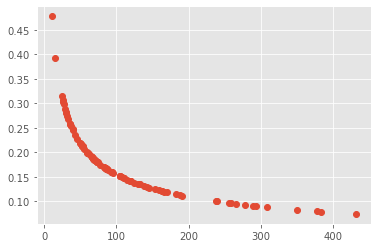

In [816]:
more_deltas = [delta_BS_root_put(x0,y0, 1,1,price, 0.1, r, sigma) for price in last_price]
plt.plot(last_price, more_deltas, 'o')

(-10.622028532684077, 200.0)

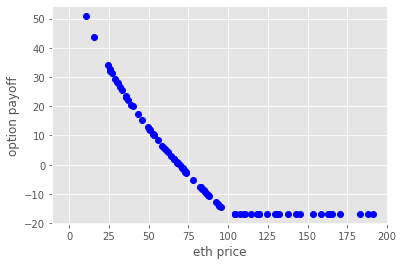

In [809]:
plt.plot(last_price, true_payoff, 'bo')
plt.xlabel('eth price')
plt.ylabel('option payoff')
plt.xlim(xmax=200)

(-10.622028532684077, 200.0)

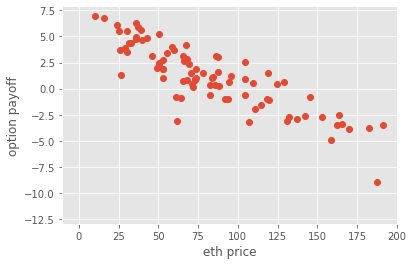

In [810]:
plt.plot(last_price, replicated_payoff, 'o')
plt.xlabel('eth price')
plt.ylabel('option payoff')
plt.xlim(xmax=200)

In [765]:
norm.rvs()

1.1922201331069668

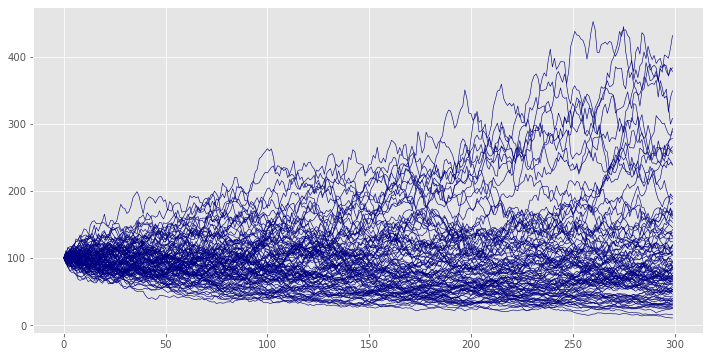

In [619]:
# geometric bwornian motions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

steps = 300
num_plots = 100
Range = []
Values = [100]

sigma = 1
T = 0.5

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))


Range = np.arange(steps) 

all_paths = []

for i in range(0, num_plots):

    for i in range (1, steps):
        dx = sigma * Values[-1] * norm.rvs() * np.sqrt(0.5 / steps)
#         if x <= 0.5:
#             x = -1
#         else:
#             x = 1
        y = Values[-1] + dx

        Values.append(y)
    all_paths.append(Values)
    ax.plot(Range, Values)
    Values = [100]

In [502]:
# print((all_paths)[0])
# plt.plot(Range, all_paths[0])

In [620]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

Text(0.5, 0, 'eth price')

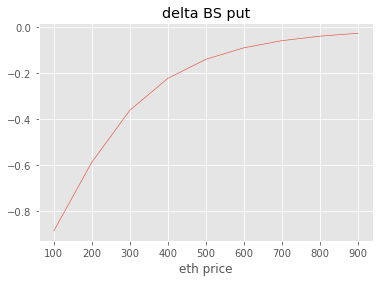

In [739]:
prices = [x for x in range(100, 1000, 100)]
deltas = [delta_BS_put(price, 300, 0.5, 0, 1) for price in prices]
plt.plot(prices, deltas)
plt.title('delta BS put')
plt.xlabel('eth price')

### This is the process of BS call replication (below):

In [621]:
# delta_BS_put(100,100,0.5, 0, 1)
last_price = []
replicated_payoff = []
true_payoff = []

S = 100
K = 100
T = 0.5
r = 0
sigma = 1

asset = 0
initial_usdc = 200
usdc = initial_usdc
prev_asset = 0

for i in range(len(all_paths[:])):
    asset = 0
    initial_usdc = 200
    usdc = initial_usdc
    prev_asset = 0
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = delta_BS_call(all_paths[i][j], K, T - t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_price.append(all_paths[i][-1])
    replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    true_payoff.append(max(0, all_paths[i][-1] - K) - BS_CALL(S, K, T, r, sigma))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

In [499]:
# print(last_price)
# print('---')
# print(replicated_payoff)

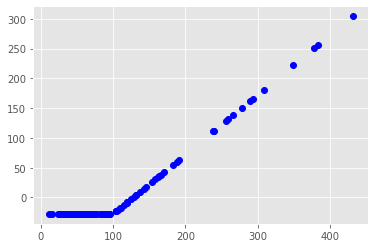

In [622]:
plt.plot(last_price, true_payoff, 'bo', )


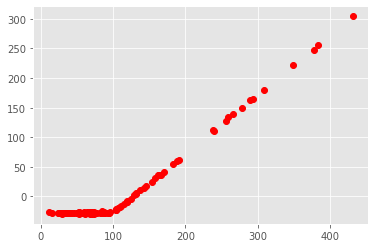

In [623]:
plt.plot(last_price, replicated_payoff, 'ro')

In [631]:
# delta_BS_put(100,100,0.5, 0, 1)
last_price = []
replicated_payoff = []
true_payoff = []

S = 100
K = 100
T = 0.5
r = 0
sigma = 1

asset = 0
initial_usdc = 0
usdc = 0
prev_asset = 0

for i in range(len(all_paths[:])):
    asset = 0
    initial_usdc = 200
    usdc = initial_usdc
    prev_asset = 0
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = delta_BS_put(all_paths[i][j], K, T - t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_price.append(all_paths[i][-1])
    replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    true_payoff.append(max(0, K - all_paths[i][-1]) - BS_PUT(S, K, T, r, sigma))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

Text(0.5, 1.0, 'true payoff')

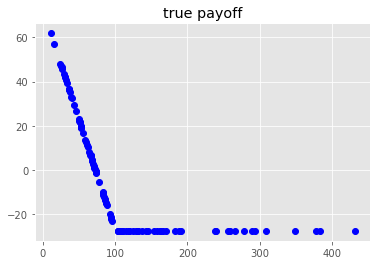

In [633]:
plt.plot(last_price, true_payoff, 'bo')
plt.title('true payoff')

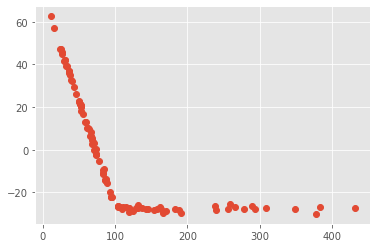

In [632]:
plt.plot(last_price, replicated_payoff, 'o')

In [149]:
    
### IT WOOOOORKS
def BS_root_put(x0, y0, x, y , S, T, r, sigma):
    
    # x0 is usdc amount
    TV0 = 2 * np.sqrt(x0 * y0) * np.sqrt()
    
    z1 = - (r - 0.5*sigma**2)*np.sqrt(T)/sigma
    first_part = (np.exp(-r*T) * TV0) * N(z1)
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
    second_part = (np.exp(-r*T) * TV0) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(z2)
    
    return first_part - second_part
    
    

    
# for comparison
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)



In [824]:
# from numpy import sqrt, sin, cos, pi, exp
import numpy as np
from scipy.integrate import quad

def num_BS_root_put_payoff(z, S0, TV0, T, r, sigma):
    return np.exp(-r*T)*(TV0 - (TV0/np.sqrt(S0)) * np.sqrt(S0)*np.exp(0.5 * (r - 0.5*sigma**2)*T + 0.5*sigma*np.sqrt(T)*z)) * norm.pdf(z)





In [825]:
# S0 = 1000
# K = 1000
T = 0.5
r = 0  
sigma = 1

x0 = 500 # 500 usdc
S0 = 1000
y0 = 500/1000

# TV0 = 2 * x0
# BS_root_put(500, 0.5 , 1, 1, 1000, 0.5, 0, 1)

z2 = - (r - 0.5*sigma**2)*np.sqrt(T)/sigma
# print(z2)

I = quad(num_BS_root_put_payoff, -100, z2, args=(1000,1000,0.5,0,1))
print(I)
# num_BS_root_put_payoff(z2, S0, TV0, T, r, sigma)

(168.45666367738062, 8.213596304289771e-10)


In [97]:
# X = [x for x in range(-15000, 0)]
# Y = [quad(num_BS_root_put_payoff, x, z2, args=(S0,TV0,T,r,sigma)) for x in X]

In [39]:
norm.pdf(0)

0.3989422804014327